In [1]:
! pip3 install tensorflow==2.12.0
! pip3 install soundfile 
! pip3 install librosa
! pip3 install matplotlib 


In [2]:
import tensorflow as tf
from functions import *

# MAKE DUA VISIBLE DEVICES -1

import os 

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



2024-04-16 03:35:13.784969: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 03:35:13.814390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 03:35:14.688313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-04-16 03:35:17.525970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 03:35:17.735364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 03:35:17.735506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import gc
gc.collect()


22

In [4]:
from tensorflow.keras.backend import clear_session
clear_session()


In [5]:
import hyperparameters as hp


directory_path = 'LA/ASVspoof2019_LA_train/flac'

In [6]:
import os
import tensorflow as tf

labels = []
file_names = []
tensors = []

directory_path_train = 'LA/ASVspoof2019_LA_train/flac'
directory_path_val = 'LA/ASVspoof2019_LA_dev/flac'

if os.path.exists('dataset_pickle_dumps/train_dataset_dumped.pkl'):
    print("LOADING TRAIN DATASET FROM FILE")
    dataset = tf.data.experimental.load('dataset_pickle_dumps/train_dataset_dumped.pkl')
    print("TRAIN DATASET LOADED FROM FILE")
else:
    with open('train_preprocessed.txt', 'r') as file:
        train_data = file.readlines()
    with open('val_preprocessed.txt', 'r') as file:
        val_data = file.readlines()

    # Combine data and also keep track of their source
    data = [(line, 'train') for line in train_data] + [(line, 'val') for line in val_data]
    data = data[:30000]


    for line, source in data:
        file_name, label = line.split()
        file_names.append((file_name, source))
        labels.append(int(label))

    ctr = 0

    for file_name, source in file_names:
        ctr += 1
        if ctr % 200 == 0:
            print(f"PROGRESS: {ctr}/{len(file_names)}")
        if source == 'train':
            file_path = os.path.join(directory_path_train, file_name)
        else:
            file_path = os.path.join(directory_path_val, file_name)
        signal, sample_rate = read_flac_file(file_path)
        lfcc_features = extract_lfcc(signal, sample_rate)
        tensor = tf.convert_to_tensor(lfcc_features)
        tensor = tf.expand_dims(tensor, axis=0)
        tensors.append(tensor[0])
        
    labels = tf.convert_to_tensor(labels)

    # pickle dump labels and tensors
    import pickle
    with open('dataset_pickle_dumps/labels_train.pkl', 'wb') as file:
        pickle.dump(labels, file)
    with open('dataset_pickle_dumps/tensors_train.pkl', 'wb') as file:
        pickle.dump(tensors, file)

    dataset = tf.data.Dataset.from_tensor_slices((tensors, labels))

    dataset = dataset.shuffle(buffer_size=len(tensors)).batch(32)

    tf.data.experimental.save(dataset, 'dataset_pickle_dumps/train_dataset_dumped.pkl')

    print("TRAIN DATASET DUMPED TO FILE")

print("NUMBER OF ENTRIES IN TRAINING DATASET: ", len(dataset))


LOADING TRAIN DATASET FROM FILE
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-04-16 03:35:17.840785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 03:35:17.840962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 03:35:17.841043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

TRAIN DATASET LOADED FROM FILE
NUMBER OF ENTRIES IN TRAINING DATASET:  938


# Subclassing the Model Class

In [ ]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.reshape = layers.Reshape((1, 1, self.filters))
        self.conv1 = layers.Conv2D(self.filters // self.ratio, 1, activation='relu',  data_format='channels_last')
        self.conv2 = layers.Conv2D(self.filters, 1, activation='sigmoid',  data_format='channels_last')
        self.multiply = layers.Multiply()

    def call(self, inputs):
        se = layers.GlobalAveragePooling2D()(inputs)
        se = self.reshape(se)
        se = self.conv1(se)
        se = self.conv2(se)
        return self.multiply([inputs, se])


class MBConv1Block (tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, filters=16, dropout_rate=0.2):
        super(MBConv1Block, self).__init__()
        self.dconv = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same',  data_format='channels_last')
        self.swish1 = tf.keras.layers.Activation('swish')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(ratio = 16)
        self.conv = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', activation=tf.keras.activations.sigmoid,  data_format='channels_last')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        
    def call(self, input):
        output = self.dconv(input)
        output = self.batch_norm1(output)
        output = self.swish1(output)
        output = self.se(output)
        output = self.conv(output)
        output = self.batch_norm2(output)
        return output
    
class MBConv6Block (tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, filters=16, dropout_rate=0.2):
        super(MBConv6Block, self).__init__()
        self.filters = filters
        self.conv1 = tf.keras.layers.Conv2D(filters * 6, (1, 1), padding='same', activation=tf.keras.activations.relu,  data_format='channels_last')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.swish1 = tf.keras.layers.Activation('swish')
        self.dconv = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')
        self.swish2 = tf.keras.layers.Activation('swish')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(ratio = 16)
        self.conv2 = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def build(self, input_shape):
        self.input_conv = tf.keras.layers.Conv2D(self.filters, (1, 1), padding='same')
        
    def call(self, input):
        input_processed = self.input_conv(input)
        output = self.conv1(input)
        output = self.batch_norm1(output)
        output = self.swish1(output)
        output = self.dconv(output)
        output = self.swish2(output)
        output = self.batch_norm2(output)
        output = self.se(output)
        output = self.conv2(output)
        output = self.batch_norm3(output)
        output = self.dropout(output)
        output = output + input_processed
        return output

    

class BasicBlock (tf.keras.layers.Layer):
    def __init__(self,C_in,C_out):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_last')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_last')
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, input):
        input = self.conv1(input)
        input = self.bn1(input)
        input = self.conv2(input)
        input = self.bn2(input)
        return input
    

class AttentionBranch (tf.keras.Model):
    def __init__(self,):
        super(AttentionBranch, self).__init__()
        self.bb1 = BasicBlock(1,2)
        self.bb2 = BasicBlock(2,4)
        self.bb3 = BasicBlock(4,8)
        self.bb4 = BasicBlock(8,16)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', data_format='channels_last')
        self.relu = tf.keras.layers.ReLU()
        self.ab_output_conv = tf.keras.layers.Conv2D(2, (1, 1), padding='same', data_format='channels_last')
        self.ab_output_gap = tf.keras.layers.GlobalAveragePooling2D()
        self.ab_output_softmax = tf.keras.layers.Softmax()
        self.attention_map_conv = tf.keras.layers.Conv2D(1, (1, 1), padding='same', data_format='channels_last')
        self.attention_map_bn = tf.keras.layers.BatchNormalization()
        self.attention_map_sigmoid = tf.keras.layers.Activation('sigmoid')
    
    def call (self, input):
        output = self.bb1(input)
        output = self.bb2(output)
        output = self.bb3(output)
        output = self.bb4(output)
        output = self.bn1(output)
        output = self.conv1(output)
        output = self.relu(output)
        ab_output =  self.ab_output_conv(output)
        ab_output = self.ab_output_gap(ab_output)
        ab_output = self.ab_output_softmax(ab_output)
        attention_map = self.attention_map_conv(output)
        attention_map = self.attention_map_bn(attention_map)
        attention_map = self.attention_map_sigmoid(attention_map)
        return ab_output, attention_map
        
        

In [ ]:
class EfficientNetA0(tf.keras.Model):
    def __init__(self, output_dim = 2, dropout=0.2):
        super(EfficientNetA0, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same', data_format='channels_last')
        self.mbconv1_1 = MBConv1Block(filters = 32, dropout_rate=dropout)
        self.mbconv6_1 = MBConv6Block(filters = 32, dropout_rate=dropout)
        self.mbconv6_2 = MBConv6Block(filters = 48, dropout_rate=dropout)
        self.mbconv6_3 = MBConv6Block(filters = 48, dropout_rate=dropout)
        self.mbconv6_4 = MBConv6Block(filters = 64, dropout_rate=dropout)
        self.mbconv6_5 = MBConv6Block(filters = 64, dropout_rate=dropout)
        self.conv2 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', data_format='channels_last')
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(output_dim)
         
    def call(self, input):
        output = self.conv1(input)
        output = self.mbconv1_1(output)
        output = self.mbconv6_1(output)
        output = self.mbconv6_2(output)
        output = self.mbconv6_3(output)
        output = self.mbconv6_4(output)
        output = self.mbconv6_5(output)
        output = self.conv2(output)
        output = self.dropout(output)
        output = self.global_avg_pool(output)
        output = self.dense(output)
        return output


        

In [ ]:
class EABNModel(tf.keras.Model):
    def __init__(self, dropout=0.2):
        super(EABNModel, self).__init__()
        self.efficientnet = EfficientNetA0(dropout=dropout)
        self.attention_branch = AttentionBranch()
    
    def call(self, input):
        ab_output, attention_map = self.attention_branch(input)
        perception_input = input * attention_map
        perception_input = perception_input + input
        perception_output = self.efficientnet(perception_input)
        return ab_output, perception_output

# Functional API Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# def se_block(input_tensor, ratio=16):
#     filters = input_tensor.shape[-1]
#     se = layers.GlobalAveragePooling2D()(input_tensor)
#     se = layers.Reshape((1, 1, filters))(se)
#     se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
#     se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
#     return layers.Multiply()([input_tensor, se])

# def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
#     x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = se_block(x)
#     x = layers.Conv2D(filters, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     x = layers.BatchNormalization()(x)
#     return layers.Add()([x, input_tensor])

# def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
#     input_filters = input_tensor.shape[-1]
#     if input_filters != filters:
#         shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
#         shortcut = layers.BatchNormalization()(shortcut)
#     else:
#         shortcut = input_tensor

#     x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = se_block(x)
#     x = layers.Conv2D(filters, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     x = layers.BatchNormalization()(x)
#     return layers.Add()([x, shortcut])

# def BasicBlock(input_tensor, c_in, c_out):
#     x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     return x

# def attention_branch(input_tensor):
#     x = BasicBlock(input_tensor, 1, 2)
#     x = BasicBlock(x, 2, 4)
#     x = BasicBlock(x, 4, 8)
#     x = BasicBlock(x, 8, 16)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(16, (1, 1), padding='same')(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv2D(1, (1, 1), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     A = layers.Activation('sigmoid')(x)
#     return A

# def EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T), dropout_rate=0.2):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
#     x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
#     x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
#     x = layers.Conv2D(1280, (1, 1), padding='same')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     R = layers.GlobalAveragePooling2D()(x)
#     R_output = layers.Dense(1, activation='sigmoid')(R)
#     A = attention_branch(inputs)
#     A_adjusted = layers.GlobalAveragePooling2D()(A)
#     A_adjusted = layers.Reshape((1,))(A_adjusted)
#     combined_output = R_output + R_output * A_adjusted
#     model = models.Model(inputs, combined_output)
#     return model

# Adding regularization 


import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, losses

def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, input_tensor])

def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    input_filters = input_tensor.shape[-1]
    if input_filters != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, shortcut])

def BasicBlock(input_tensor, c_in, c_out):
    x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_branch(input_tensor):
    x = BasicBlock(input_tensor, 1, 2)
    x = BasicBlock(x, 2, 4)
    x = BasicBlock(x, 4, 8)
    x = BasicBlock(x, 8, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (1, 1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    A = layers.Activation('sigmoid')(x)
    return A

def TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = layers.Dropout(rate)(attention_output)
    out1 = layers.LayerNormalization()(inputs + attention_output)
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = layers.Dropout(rate)(ffn_output)
    final_output = layers.LayerNormalization()(out1 + ffn_output)
    return models.Model(inputs, final_output)

def EfficientNet_A0_with_attention(input_shape=(1, 257, 400), dropout_rate=0.2):  # Example dimensions
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
    x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = layers.Conv2D(1280, (1, 1), padding='same')(x)
    x = layers.Reshape((-1, 1280))(x)  # Reshape for Transformer block
    transformer_model = TransformerBlock(1280, 8, 512)
    x = transformer_model(x)  # Apply the transformer model directly
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    R_output = layers.Dense(1, activation='sigmoid')(x)
    A = attention_branch(inputs)
    A = layers.GlobalAveragePooling2D()(A)
    A_adjusted = layers.Reshape((1,))(A)
    combined_output = R_output + R_output * A_adjusted
    model = models.Model(inputs, combined_output)
    return model

def custom_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    reg = regularizers.l2(0.06)
    regularization = tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)
    loss = bce + regularization
    return loss

# Adjust hp.F and hp.T to your actual feature and time dimensions
model = EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T))
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 30, 300)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1, 30, 32)    9632        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 30, 32)    9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 30, 32)   128         ['conv2d_1[0][0]']         

In [8]:
'''
labels

one_ctr = 0 
zero_ctr = 0 

for i in labels : 
    if i == 0: 
        zero_ctr +=1
    else : 
        one_ctr +=1

print(one_ctr , zero_ctr)
'''

'\nlabels\n\none_ctr = 0 \nzero_ctr = 0 \n\nfor i in labels : \n    if i == 0: \n        zero_ctr +=1\n    else : \n        one_ctr +=1\n\nprint(one_ctr , zero_ctr)\n'

# Model Training 

In [9]:
from keras.callbacks import Callback
import numpy as np
from scipy.special import softmax
from sklearn.metrics import roc_curve
import os, tensorflow as tf, pickle

model_path = 'model.keras'
test_data_path = 'test_preprocessed.txt'
directory_path = 'LA/ASVspoof2019_LA_eval/flac'
pickle_path = 'test_data_cache.pkl'

def custom_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    reg = tf.keras.regularizers.l2(0.06)
    return bce + tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})
    print("Model loaded from disk")
else:
    model = EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T))
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
    print("Model created from scratch")

class ClassWiseAccuracy(Callback):
    def __init__(self, train_dataset, val_dataset):
        super().__init__()
        self.train_dataset, self.val_dataset = train_dataset, val_dataset
        self.epoch_counter = 0
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        if self.epoch_counter % 5 == 0:
            for dataset, name in [(self.train_dataset, 'Train'), (self.val_dataset, 'Test')]:
                y_true, y_scores = [], []
                for x, y in dataset:
                    y_true.extend(y.numpy())
                    preds = self.model.predict(x, verbose=0)
                    preds = np.hstack([1 - preds, preds]) if preds.shape[1] == 1 else preds
                    y_scores.extend(softmax(preds, axis=1)[:, 1])
                y_true, y_scores = np.array(y_true), np.array(y_scores)
                fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
                y_pred = (y_scores > thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]).astype(int)
                class_acc = [np.mean(y_pred[y_true == k] == y_true[y_true == k]) for k in np.unique(y_true)]
                for i, acc in enumerate(class_acc):
                    print(f"{name} Accuracy for class {i}: {acc}")
                print(f"{name} EER: {eer}")

if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        tensors, labels = pickle.load(f)
        
else:
    file_names, labels = [], []
    with open(test_data_path) as text_file:
        for line in text_file:
            file_name, label = line.split()
            file_names.append(file_name)
            labels.append(int(label))
    tensors = []
    for file_name in file_names:
        signal, rate = read_flac_file(os.path.join(directory_path, file_name))
        lfcc = extract_lfcc(signal, rate)
        tensors.append(tf.expand_dims(tf.convert_to_tensor(lfcc), axis=0)[0])
    with open(pickle_path, 'wb') as f:
        pickle.dump((tensors, labels), f)

dataset_val = tf.data.Dataset.from_tensor_slices((tensors, labels)).shuffle(len(tensors)).batch(32)
train_dataset = dataset
model.fit(train_dataset, epochs=hp.n_epochs_training, callbacks=[ClassWiseAccuracy(train_dataset, dataset_val)])
model.save(model_path)


Model loaded from disk
Epoch 1/20


2024-04-16 03:35:25.414299: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-16 03:35:26.195775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-16 03:35:26.257530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-04-16 03:35:27.120984: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7645f13ac5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 03:35:27.121016: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-04-16 03:35:27.188027: I tensorflow/compiler/mlir/tensorflow/utils/dum

938/938 [==============================] - 74s 63ms/step - loss: 0.8643 - accuracy: 0.8997
Epoch 2/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8629 - accuracy: 0.9038
Epoch 3/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8622 - accuracy: 0.9085
Epoch 4/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8616 - accuracy: 0.9111
Epoch 5/20
937/938 [============================>.] - ETA: 0s - loss: 0.8613 - accuracy: 0.9129Train Accuracy for class 0: 0.9654836193447738
Train Accuracy for class 1: 0.9651817304599549
Train EER: 0.03471138845553822


2024-04-16 03:41:10.455136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-04-16 03:41:10.455320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Test Accuracy for class 0: 0.8837863167760075
Test Accuracy for class 1: 0.8832419120116423
Test EER: 0.1162136832239925
938/938 [==============================] - 113s 121ms/step - loss: 0.8612 - accuracy: 0.9128
Epoch 6/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8607 - accuracy: 0.9155
Epoch 7/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8605 - accuracy: 0.9158
Epoch 8/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8600 - accuracy: 0.9178
Epoch 9/20
938/938 [==============================] - 58s 62ms/step - loss: 0.8596 - accuracy: 0.9203
Epoch 10/20
937/938 [============================>.] - ETA: 0s - loss: 0.8593 - accuracy: 0.9207Train Accuracy for class 0: 0.9664586583463338
Train Accuracy for class 1: 0.9666693470569315
Train EER: 0.033541341653666144
Test Accuracy for class 0: 0.880037488284911
Test Accuracy for class 1: 0.8799955222209784
Test EER: 0.11996251171508904
938/938 [==========================

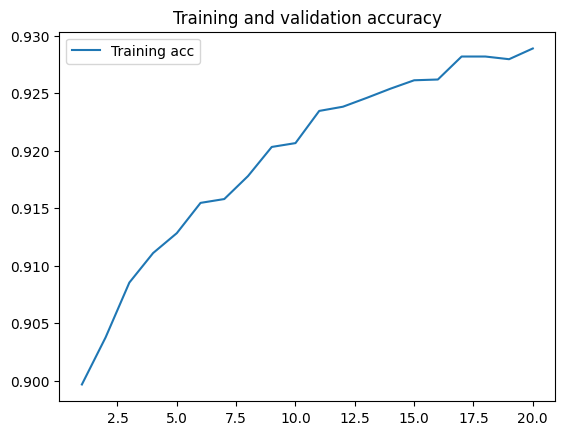

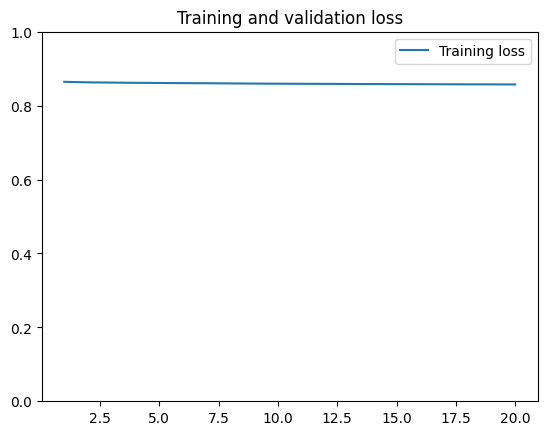

In [10]:
def plot_history(history):
    import matplotlib.pyplot as plt
    
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    # plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    # plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

plot_history(model.history)

In [11]:
# load model from pkl

# model = tf.keras.models.load_model('model.keras')


# model.evaluate(dataset_val)
# predictions = model.predict(dataset_val)